In [30]:
#Import thư viện
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [31]:
import pandas as pd

In [32]:
#import file xlxs
df = pd.read_excel('../Dataset/ADAUSDT.xlsx')

In [33]:
#Chuyển dữ liệu Close time trong DataFrame từ chuỗi sang Datetime theo định dạng ngày tháng năm
def convert_date(s):
  return datetime.strptime(s, "%d-%m-%Y")
df['Close time']=df['Close time'].apply(convert_date)

In [34]:
#Sắp xếp close time theo thứ tự tăng dần
#chuyển cột close time thành index cho dataframe 
#Do là dữ liệu này mang tính time series, Nên index của mỗi dòng nên là thời gian Để đảm bảo tính time series cho dữ liệu
df=df.set_index('Close time').sort_index()

#in ra 5 dòng đầu tiên của dataframe sau khi đã sắp xếp từ quá khứ đến hiện tại
df.head()



,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
Close time,,,,,,,,,,,
2019-03-22,21-03-2019,0.054,0.055,0.050,0.052,286797501.8,1.504575e+07,41525,131454870.8,6.908864e+06,0
2019-03-23,22-03-2019,0.052,0.059,0.052,0.058,421719603.6,2.380675e+07,66113,213984777.7,1.206511e+07,0
2019-03-24,23-03-2019,0.058,0.065,0.057,0.063,534272459.0,3.255881e+07,86175,256813665.5,1.561654e+07,0
2019-03-25,24-03-2019,0.063,0.065,0.059,0.062,415661855.5,2.550184e+07,71173,204932507.5,1.257689e+07,0
2019-03-26,25-03-2019,0.061,0.062,0.056,0.059,313417482.6,1.850517e+07,49172,158432327.9,9.364228e+06,0


In [35]:
#in thông tin
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2019-03-22 to 2023-03-29
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     1500 non-null   object 
 1   Open                          1500 non-null   float64
 2   High                          1500 non-null   float64
 3   Low                           1500 non-null   float64
 4   Close                         1500 non-null   float64
 5   Volume                        1500 non-null   float64
 6   Quote asset volume            1500 non-null   float64
 7   Number of trades              1500 non-null   int64  
 8   Taker buy base asset volume   1500 non-null   float64
 9   Taker buy quote asset volume  1500 non-null   float64
 10  Ignore                        1500 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 140.6+ KB


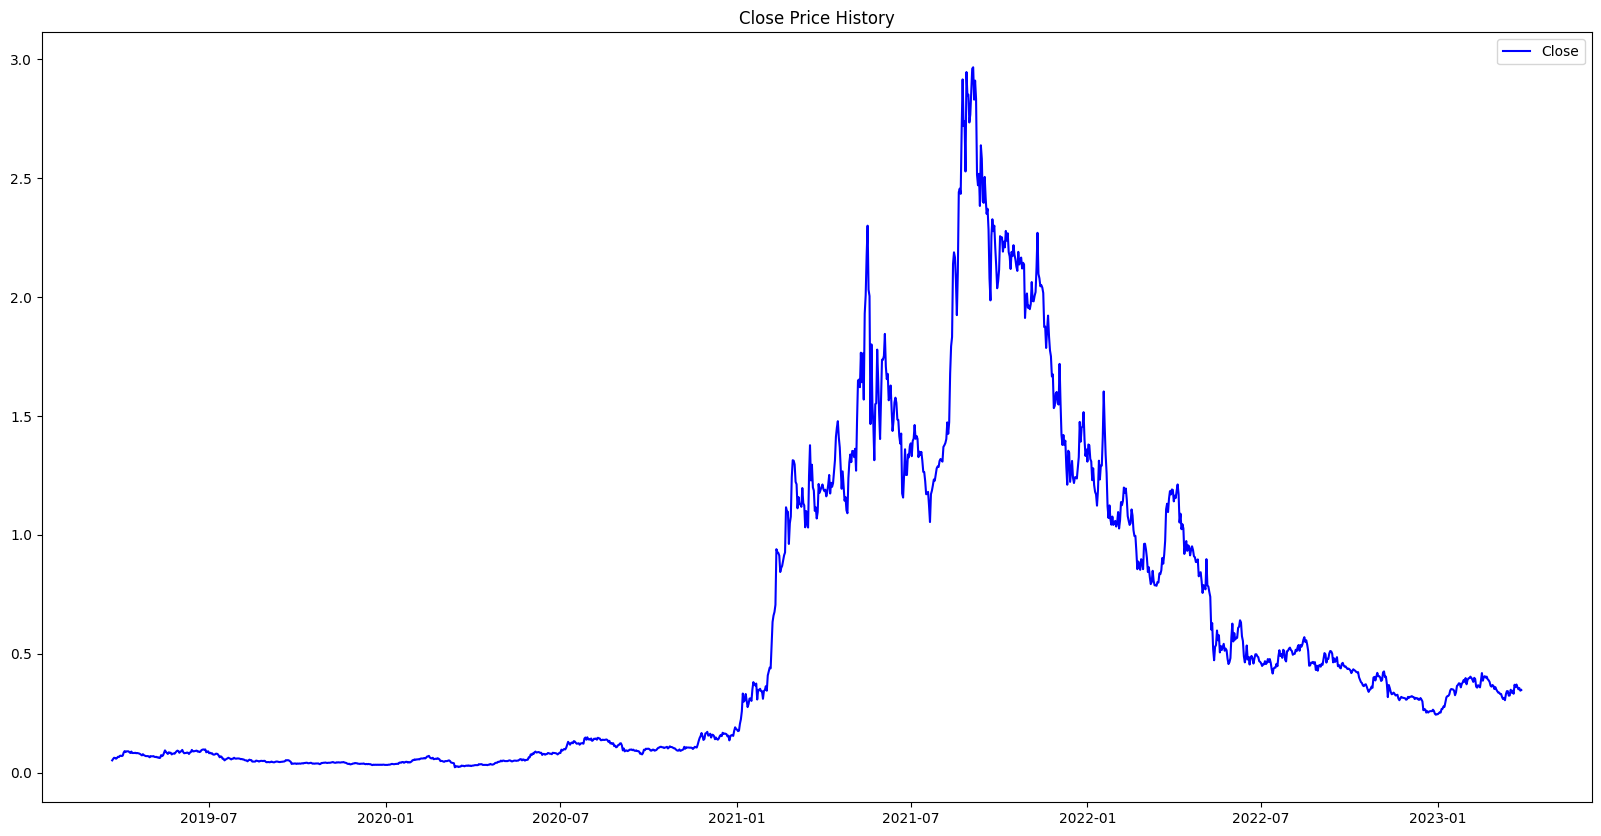

In [36]:
#vẽ biểu đồ giá đóng cửa theo thời gian
plt.figure(figsize=(20,10))
plt.plot(df.index, df['Close'], color='blue', label='Close')
plt.legend(loc='best')
plt.title('Close Price History')
plt.show()


In [37]:
#lấy dữ liệu giá đóng cửa
df = df[['Close']]

#Chia tập dữ liệu thành tập train, val và test theo tỷ lệ 7-1-2
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

train, val, test = df.iloc[0:train_size], df.iloc[train_size:train_size+val_size], df.iloc[train_size+val_size:len(df)]
#in ra kích thước của tập train, val và test
print(len(train), len(val), len(test))
print(train.shape, val.shape, test.shape)

1050 150 300
(1050, 1) (150, 1) (300, 1)


In [38]:
#chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Close']])
val_scaled = scaler.transform(val[['Close']])
test_scaled = scaler.transform(test[['Close']])
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)

#in dữ liệu sau khi chuẩn hóa
print(train_scaled[0:5])
print(val_scaled[0:5])
print(test_scaled[0:5])


(1050, 1) (150, 1) (300, 1)
[[0.00985389]
 [0.01189263]
 [0.01359157]
 [0.01325178]
 [0.01223242]]
[[0.44036697]
 [0.43696908]
 [0.41012572]
 [0.42711519]
 [0.40332994]]
[[0.19164118]
 [0.18246687]
 [0.1848454 ]
 [0.1848454 ]
 [0.19911655]]


Tiếp theo, bạn cần tiến hành huấn luyện mô hình với thuật toán SVR. Bạn có thể sử dụng GridSearchCV để tìm kiếm các tham số tối ưu cho mô hình.

In [39]:
print(train_scaled.shape, val_scaled.shape, test_scaled.shape)


#Xây dựng model SVR
# Tạo dữ liệu đầu vào và đầu ra cho model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


#Thiết lập tham số cho model
look_back = 30
X_train, y_train = create_dataset(train_scaled, look_back)
X_val, y_val = create_dataset(val_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)



print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)



(1050, 1) (150, 1) (300, 1)
(1019, 30) (1019,)
(119, 30) (119,)
(269, 30) (269,)


In [40]:
#Xây dựng model
#Khởi tạo model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

clf = SVR()

# Thiết lập phạm vi tốt cho các tham số
C_range = np.logspace(-3, 3, 10) #tạo ra 10 giá trị trong khoảng từ 10^-3 đến 10^3
gamma_range = np.logspace(-3, 3, 10) #tạo ra 10 giá trị trong khoảng từ 10^-3 đến 10^3
kernel_range = ['rbf', 'linear', 'sigmoid'] #tạo ra 3 giá trị cho kernel

# Tạo lưới các giá trị tham số
param_grid = {'C': C_range, 'gamma': gamma_range, 'kernel': kernel_range}

# Thiết lập model với các tham số và số lượng folds cross-validation
model = GridSearchCV(clf, param_grid, refit=True, verbose=3, cv=5, scoring='neg_mean_squared_error')
#trong đó:
#clf: model
#param_grid: tham số
#refit: lưu lại model tốt nhất
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE

# Huấn luyện model
model.fit(X_train, y_train)




Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.016 total time=   0.6s
[CV 2/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.017 total time=   0.6s
[CV 3/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.008 total time=   0.6s
[CV 4/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.092 total time=   0.3s
[CV 5/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.291 total time=   0.2s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.010 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.010 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.008 total time=   0.0s
[CV 4/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.005 total time=   0.0s
[CV 5/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.035 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=-0.016 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.00

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [41]:
#In ra tham số tốt nhất
print(model.best_params_)
print(model.best_estimator_)
print(model.best_score_)

{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}
SVR(C=10.0, gamma=0.001, kernel='linear')
-0.0020508685598803087


In [42]:
#in kích thước của tập train, val và test
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)



#thử nghiệm model trên tập validation và test để đánh giá điểm số của model (MSE) vừa tìm được trên grid search
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)



(1019, 30) (1019,)
(119, 30) (119,)
(269, 30) (269,)


In [43]:
#reshape y_val và y_test về cùng shape với y_val_pred và y_test_pred
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#chuẩn hóa dữ liệu về cùng scale với y_val_pred và y_test_pred
y_val = scaler.inverse_transform(y_val)
y_test = scaler.inverse_transform(y_test)


#Đánh giá model bằng MSE
print('MSE val: ', mean_squared_error(y_val, y_val_pred))
print('MSE test: ', mean_squared_error(y_test, y_test_pred))


MSE val:  0.3547246970098793
MSE test:  0.07093262537207952


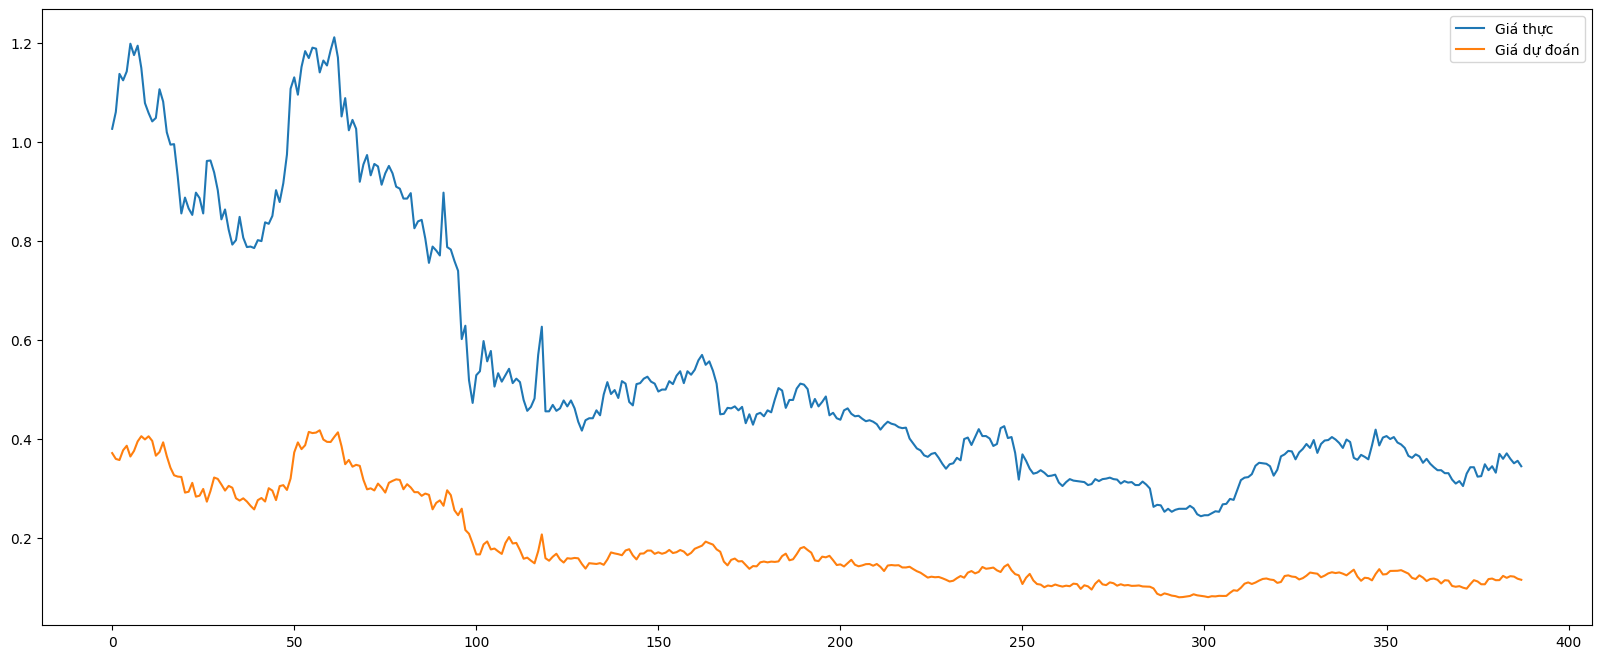

In [44]:
#ghép dữ liệu dự đoán trên tập validation và test vào dữ liệu gốc
y_pred = np.concatenate((y_val_pred, y_test_pred), axis=0)
y_true = np.concatenate((y_val, y_test), axis=0)

#Vẽ biểu đồ
plt.figure(figsize=(20, 8))
plt.plot(y_true, label='Giá thực')
plt.plot(y_pred, label='Giá dự đoán')
plt.legend()
plt.show()


sử dụng mô hình đã huấn luyện để dự đoán giá trị Close của 30 ngày tiếp theo bằng cách sử dụng phương thức predict():

Tạo tập dữ liệu giả cho các dự đoán trong tương lai

In [45]:
#Dự đoán 30 ngày tiếp theo
#Lấy ra 30 ngày cuối cùng của dữ liệu theo thứ tự thời gian của giá trị 'Close'
last_data = np.array(df['Close'].tail(look_back))
print(last_data.shape)

# Reshape last_data để có kích thước (1, lookback)
last_data = last_data.reshape((1, look_back))


future_days = 30

#tạo mảng chứa 30 ngày tiếp theo
furture_pred = []

#tạo vòng lặp dự đoán 30 ngày tiếp theo
for i in range(future_days):
    # Dự đoán giá chứng khoán cho ngày tiếp theo sử dụng dữ liệu của last_data
    next_day_prediction = model.predict(last_data)[0]
    # Thêm giá dự đoán được vào mảng furture_pred
    furture_pred.append(next_day_prediction)
    # Cập nhật lại last_data bằng cách thêm giá dự đoán được vào cuối mảng last_data
    last_data = np.append(last_data[:, 1:], [[next_day_prediction]], axis=1)
    last_data = last_data.reshape((1, look_back))



(30,)


In [46]:
#in ra giá trị thưc của 30 ngày tiếp theo
print('Giá thực: ', df['Close'].tail(30).values)

#in ra giá trị dự đoán của 30 ngày tiếp theo
print('Giá dự đoán: ', furture_pred)

Giá thực:  [0.365 0.352 0.36  0.35  0.343 0.337 0.337 0.331 0.331 0.318 0.31  0.315
 0.305 0.33  0.343 0.343 0.324 0.325 0.349 0.337 0.345 0.332 0.37  0.36
 0.371 0.36  0.351 0.356 0.345 0.348]
Giá dự đoán:  [0.36474977287291693, 0.38331285245153474, 0.3921392910648715, 0.39882546788443335, 0.4062620969227146, 0.405638563045652, 0.3952631042028875, 0.3985719314433988, 0.40937839463092146, 0.42819339327099065, 0.4384436211203772, 0.44852768871281107, 0.46099910714599573, 0.4569483774285454, 0.4525531699759581, 0.448558450178488, 0.4501337999033583, 0.46331202837105095, 0.4745591558612285, 0.4924961328038075, 0.5065265745683577, 0.5171730840006953, 0.5133853573580106, 0.5031424607726377, 0.5014918570624646, 0.4984592568209342, 0.5029883971810983, 0.5146419025280012, 0.5307404985034475, 0.5446380431964885]


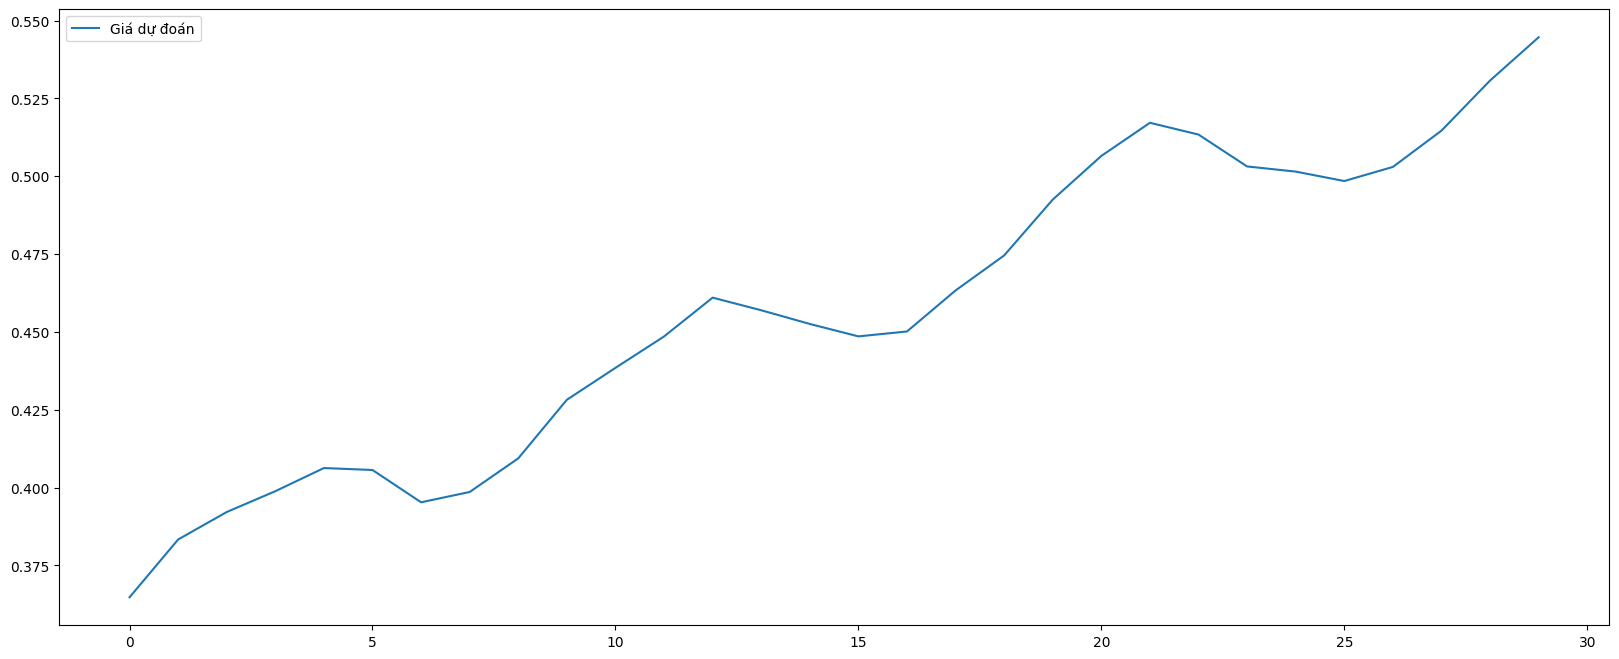

In [47]:
#Vẽ biểu đồ
plt.figure(figsize=(20, 8))
plt.plot(furture_pred, label='Giá dự đoán')
plt.legend()
plt.show()

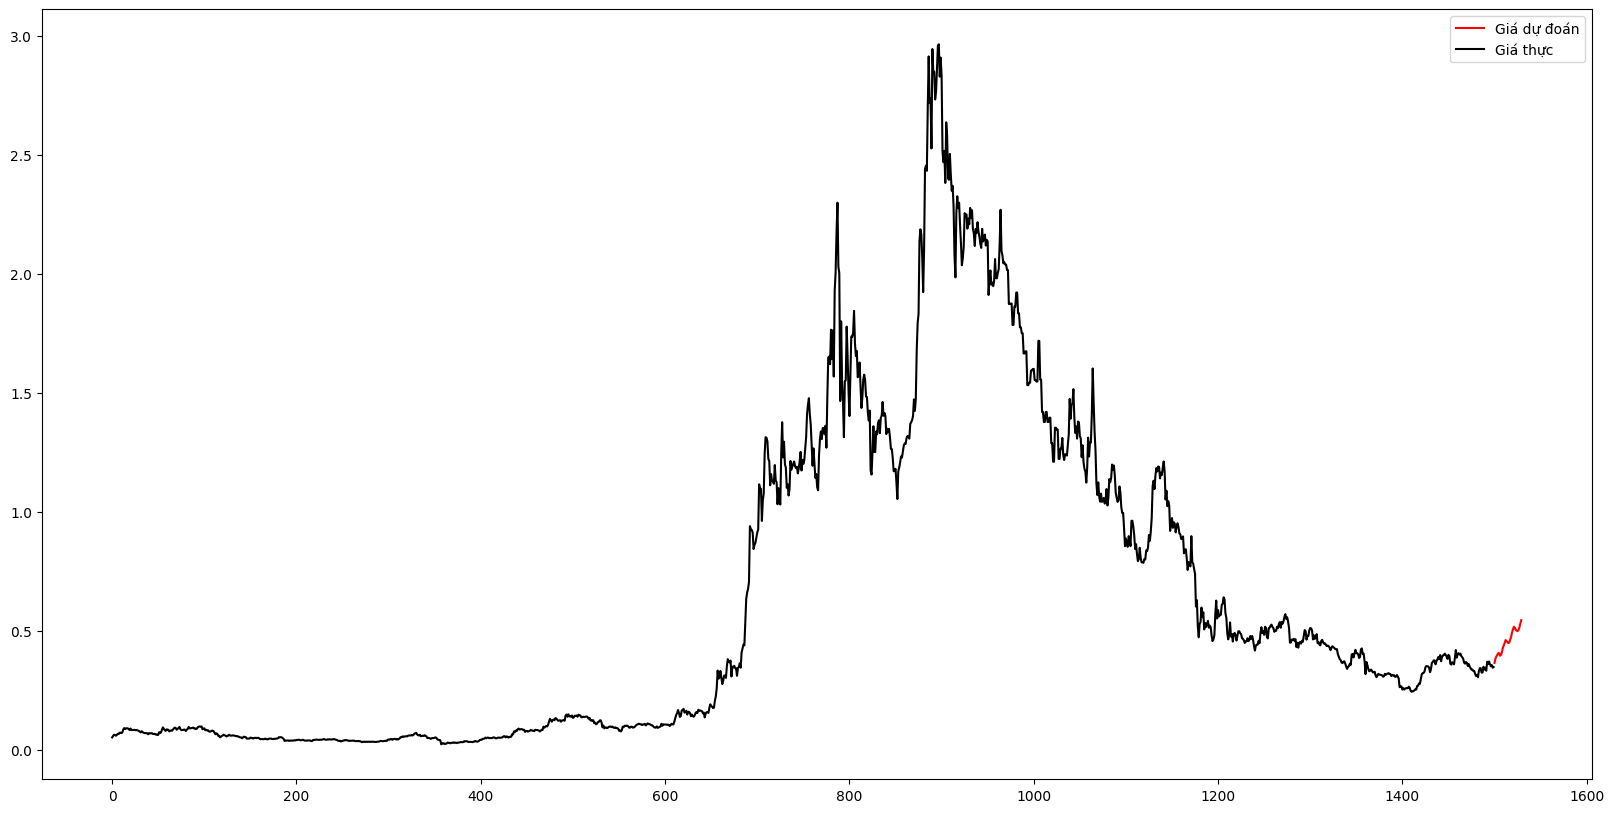

In [48]:
#tạo mảng index tương ứng với các ngày tiếp theo
days = np.array(range(len(df), len(df) + future_days))

#Vẽ biểu đồ
plt.figure(figsize=(20, 10))
plt.plot(days, furture_pred,c='r', label='Giá dự đoán')
plt.plot(df['Close'].values, c='black',label='Giá thực')
plt.legend()
plt.show()